# Example: Optimal stopping of fractional Brownian motion

In this notebook we show how to use the code from https://github.com/lucapelizzari/Optimal_Stopping_with_signatures/tree/main to compute lower and upper bounds for the optimal stopping value of fractional Brownian motion, see Section 4.1 in https://arxiv.org/abs/2312.03444, and additionally we show how to improve duality gaps using deep neural networks.

The repository consists of:

*   Simulation packages for fractional Brownian motion, rough Bergomi and rough Heston models
*   A modul for signature related computations **Signature_computer.py**, which can compute the signature and log-signature  of various lifts related to volatility modelling, with the additional option of adding polynomials of the state-process and/or volatility.
*   The main module for the linear signature approaches **Linear_signature_optimal_stopping.py**, which can be used to derive lower and upper bounds to the optimal stopping problem applying the approaches described in https://arxiv.org/abs/2312.03444
*   The main module for deep log-signature approaches **Deep_signature_optimal_stopping.py**, which extends the linear approaches by applying deep neural networks on the log-signature. This code is accompanying a working paper paper on "American option pricing using signatures"





Recall from Section 4.1 in the paper, that we wish to solve the problem $$\sup_{\tau\in \mathcal{S}_0^{100}}\mathbb{E}(X^H_{\tau}),$$ where $X^H$ is a fractional Brownian motion with Hurst parameter $H\in (0,1)$, and we maximize over stopping times on $0=t_0<\dots<t_{100}=1$. In both the primal and dual formulation, we approximate the solution using $K$-step signature lifts of the paths $t \mapsto (t,X_t^H)$.

## Sampling fractional Brownian motion


We start by importing our package for the simulation of fBm

In [1]:
from FBM_package import FBM

We define the parameters and sample training and testing data:

In [2]:
import numpy as np
N1 = 10 #number of stopping dates
N = 100 #discretization-grid for computing the siganture (that is iterated integrals)
h = 0.3 #Hurst Parameter
T = 1 #Final time
M = 50000 #number of samples for training
M2 = 50000 #number of samples for testing


In [3]:
F_training,dfBm_training,dW_training = FBM(N,M,h,method='cholesky').fbm()
dW_training = dW_training.transpose()
F_training = F_training.transpose()

F_testing,dfBm_testing,dW_testing = FBM(N,M,h,method='cholesky').fbm()
F_testing = F_testing.transpose()
dW_testing = dW_testing.transpose()

## Signature computations

We will make us uf the iisignature package https://pypi.org/project/iisignature/ to compute the signature, and it can be installed using pip:

In [4]:
!pip install iisignature

We import our signature computation module, which can compute various signature and log signature lifts related to the generated data

In [5]:
from Signature_computer import SignatureComputer

Next we initialize the **SignatureComputer**, which allows to choose from the linear and the log signature, and various choices of signature lifts. Compared to the example of American Options, one is rather limited here and we will simply consider the lift of $(t,X_t^H)$ of degree $4$.

In [6]:
sig_computer = SignatureComputer(T, N, 4, "linear", signature_lift="normal", poly_degree=0)

In [7]:
#Compute the signature for training and test data
tt = np.linspace(0,T,N+1)
A_training = np.zeros((M, N+1)) #time-augmentation
A_testing = np.zeros((M2, N+1))
A_training[:, 1:] = A_testing[:, 1:] = tt[1:]
signatures_training = sig_computer.compute_signature(F_training, F_training, A_training, F_training)
signatures_testing = sig_computer.compute_signature(F_testing, F_testing, A_testing, F_testing)

Computing linear signature with normal lift
Computing linear signature with normal lift


ome example of the signature paths

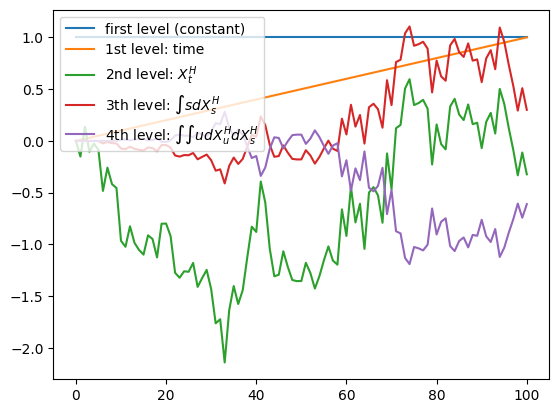

In [8]:
import matplotlib.pyplot as plt
plt.plot(signatures_training[0,:,0],label = 'first level (constant)')
plt.plot(signatures_training[0,:,1],label = '1st level: time ')
plt.plot(signatures_training[0,:,2],label = '2nd level: $X_t^H$')
plt.plot(signatures_training[0,:,4],label = '3th level: $\int sdX^H_s $')
plt.plot(signatures_training[0,:,12],label = '4th level: $\int \int udX^H_u dX^H_s $')
plt.legend(loc='upper left')

## Computing lower and upper bounds

We can now import the linear primal and dual pricers, which compute true lower and upper bounds.
- The **LinearLongstaffSchwartzPricer** uses the signature of the training data to recursively approximate continuation values in the spirit of the Longstaff-Schwartz algorithm (descibed in detail in Section 3.1 of https://arxiv.org/abs/2312.03444). The resulting regression coefficients at each exercise date provide a stopping rule, which can be applied to the testing data to get true lower-bounds
- The **LinearDualPricer** uses the signature of the training data to minimize over the familiy of linear signature martingales, by solving a corresponding linear program (described in Detail in Section 3.2 of https://arxiv.org/abs/2312.03444). The resulting coefficients yield a Doob martingale approximation, which for the testing data yields a true upper bound.
By combining the two values, we receive confidence intervals for the true option price.

To solve the linear programm, one can optionally choose to use Gurobi https://www.gurobi.com, which requires a free licence, which is recommended especially for high-dimensional LPs that occur when choosing large sample-sizes and/or high signature truncations levels. Alternatively, we use the free LP solvers from CVXPY

In [9]:
!pip install gurobipy
import cvxpy as cp

In [10]:
from Linear_signature_optimal_stopping import LinearLongstaffSchwartzPricer, LinearDualPricer

In [11]:
ls_pricer = LinearLongstaffSchwartzPricer(
        N1=N1,
        T=T,
        r=0,
        mode="Standard",
        ridge=10**(-9)
    )

dual_pricer = LinearDualPricer(
        N1=N1,
        N=N,
        T=T,
        r=0,
        LP_solver="CVXPY"
    )

In this example we set $r=0$ (no interest rate), and mode = "Standard", where the alternativ is mode = "American Option", which only uses in-the-money paths (requires non-negative payoffs).

In [12]:
lower_bound, lower_bound_std, ls_regression_models = ls_pricer.price(
        signatures_training,
        F_training,
        signatures_testing,
        F_testing
    )

Regression score at exercise date 9 0.7720749247217531
Regression score at exercise date 8 0.7072180323041455
Regression score at exercise date 7 0.6476393620019902
Regression score at exercise date 6 0.5836908743104001
Regression score at exercise date 5 0.5211294745970703
Regression score at exercise date 4 0.44911988459647145
Regression score at exercise date 3 0.375173702259168
Regression score at exercise date 2 0.2789237478951866
Regression score at exercise date 1 0.17071460868296773


In [13]:
print(f"Linear Longstaff-Schwartz lower bound: {lower_bound} ± {lower_bound_std/np.sqrt(M2)}")

Linear Longstaff-Schwartz lower bound: 0.2436758369259125 ± 0.0035850490987833178


Similarly let us derive the upper bounds, but we will train the model only for $M= 5000$ paths to reduce computation time, and then compute true prices for all testing samples.

In [14]:
M_dual = 5000
upper_bound, upper_bound_std, MG = dual_pricer.price(
        signatures_training[:M_dual,:,:],
        F_training[:M_dual,:],
        dW_training[:M_dual,:],
        signatures_testing,
        F_testing,
        dW_testing
    )

21.53 seconds needed to solve the linear program using CVXPY


In [15]:
print(f"Linear Dual upper bound: {upper_bound} ± {upper_bound_std/np.sqrt(M2)}")
print(f"Pricing interval: {(lower_bound,upper_bound)}± {np.maximum(upper_bound_std,lower_bound_std)/np.sqrt(M2)} ")

Linear Dual upper bound: 0.2701431742689744 ± 0.00046659500573156305
Pricing interval: (0.2436758369259125, 0.2701431742689744)± 0.0035850490987833178 


## Improving upper bounds using Deep Neural Networks

In forthcoming work about "American options in rough volatility models", we will focus on more non-linear apporaches to price American options. More precisely, we extend the primal and dual procedures by replacing linear functionals of the signature by deep neural networks on the log or linear signature, in order to learn highly non-linear functionals, such as the integrand of the Doob martingale ("derivative of the Snell-envelope"). Of course, in both methods, a optimization of the hyperparameters is required and this presentation here is only to get familiar with the code.

In this example, we only consider neural networks for the dual problem. (see the rough Bergomi example for both primal and dual with DNN)

In [21]:
sig_computer_deep = SignatureComputer(T, N, 4, "linear", signature_lift="normal", poly_degree=0)

In [22]:
deep_signatures_training = sig_computer_deep.compute_signature(F_training, F_training, A_training, F_training)
deep_signatures_testing = sig_computer_deep.compute_signature(F_testing, F_testing, A_testing, F_testing)

Computing linear signature with normal lift
Computing linear signature with normal lift


In [23]:
from Deep_signatures_optimal_stopping import DeepDualPricer

We consider a network with $3$ hidden layers and each with $16+\mathrm{dim}(\mathbb{X})$ neurons, and we use $relu(x)$ activation function between layers

In [26]:
dual_pricer = DeepDualPricer(
        N1=N1,
        N=N,
        T=T,
        r=0,
        layers=3,
        nodes=16,
        activation_function='relu',
        batch_normalization=False,
        regularizer=10**(-9),
        dropout=False,
        attention_layer=False,
        layer_normalization=False
    )

In [27]:
y0, upper_bound_deep, upper_bound_deep_std, dual_model, dual_rule_model = dual_pricer.price(
        deep_signatures_training,
        F_training,
        dW_training,
        deep_signatures_testing,
        F_testing,
        dW_testing,
        M_val=int(0.9*M),
        batch=2**8,
        epochs=10,
        learning_rate=0.01
    )

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.3079 - val_loss: 0.2760
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - loss: 0.2747 - val_loss: 0.2720
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.2723 - val_loss: 0.2727
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.2718 - val_loss: 0.2726
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 0.2722 - val_loss: 0.2697
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.2710 - val_loss: 0.2683
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.2693 - val_loss: 0.2684
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.2694 - val_loss: 0.2684
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - loss: 0.2685 - val_loss: 0.2680
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.2676 - val_loss: 0.2674
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


In [29]:
print(f"Deep Dual upper bound: {upper_bound_deep} ± {upper_bound_deep_std/np.sqrt(M2)}")
print(f"Improved Pricing interval: {(lower_bound,upper_bound_deep)}± {np.maximum(upper_bound_deep_std,lower_bound_std)/np.sqrt(M2)} ")

Deep Dual upper bound: 0.2672438125482347 ± 0.0004311113726898614
Improved Pricing interval: (0.2436758369259125, 0.2672438125482347)± 0.0035850490987833178 


As the learning above shows, we should probably use more epochs and consider varying learning rates to improve the performance. But already for these parameters, we see an improvement for the duality gap.